# Gas Dynamics: BaseFees 

In this notebook we examine the BaseFee and method composition to determine if particular message types drove up the BaseFee. We will start our analysis with a query for second level data for August, 2021 to September 3rd, 2021 via the `derivaged_gas_ouputs` table. This analysis was first run on September 15th, 2021.

### Hypothesis: 
storagemarket/4 - PublishStorageDeals - was one of the main drivers in the increase in gas used.

#### Change Log
* Updated from mean_base_fee to gas_used 

In [1]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
from datetime import datetime
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

from Cryptoeconomics_signal_processing import time_analysis, fourier_transform, phase_shift_overlay


%matplotlib inline

import warnings
warnings.simplefilter('ignore')



In [2]:
# load connection string
CONN_STRING_PATH = '../../config/sentinel_conn_string_andrew.txt'


with open(CONN_STRING_PATH, 'r') as fid:
    conn_string = fid.read()
    
# create database connection.
connection = create_engine(conn_string, pool_recycle=3600).connect()



## Data EDA


### `derived_gas_outputs` - coped from [Sentinel's Data Dictionary](https://github.com/filecoin-project/sentinel/blob/master/docs/db.md)
Derived gas costs resulting from execution of a message in the VM.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`actor_name`|`text`|NO|Human readable identifier for the type of the actor.|
|`base_fee_burn`|`text`|NO|The amount of FIL (in attoFIL) to burn as a result of the base fee. It is parent_base_fee (or gas_fee_cap if smaller) multiplied by gas_used. Note: successfull window PoSt messages are not charged this burn.|
|`cid`|`text`|NO|CID of the message.|
|`exit_code`|`bigint`|NO|The exit code that was returned as a result of executing the message. Exit code 0 indicates success. Codes 0-15 are reserved for use by the runtime. Codes 16-31 are common codes shared by different actors. Codes 32+ are actor specific.|
|`from`|`text`|NO|Address of actor that sent the message.|
|`gas_burned`|`bigint`|NO|The overestimated units of gas to burn. It is a portion of the difference between gas_limit and gas_used.|
|`gas_fee_cap`|`text`|NO|The maximum price that the message sender is willing to pay per unit of gas.|
|`gas_limit`|`bigint`|YES|A hard limit on the amount of gas (i.e., number of units of gas) that a message’s execution should be allowed to consume on chain. It is measured in units of gas.|
|`gas_premium`|`text`|NO|The price per unit of gas (measured in attoFIL/gas) that the message sender is willing to pay (on top of the BaseFee) to "tip" the miner that will include this message in a block.|
|`gas_refund`|`bigint`|NO|The overestimated units of gas to refund. It is a portion of the difference between gas_limit and gas_used.|
|`gas_used`|`bigint`|NO|A measure of the amount of resources (or units of gas) consumed, in order to execute a message.|
|`height`|`bigint`|NO|Epoch this message was executed at.|
|`method`|`bigint`|YES|The method number to invoke. Only unique to the actor the method is being invoked on. A method number of 0 is a plain token transfer - no method exectution.|
|`miner_penalty`|`text`|NO|Any penalty fees (in attoFIL) the miner incured while executing the message.|
|`miner_tip`|`text`|NO|The amount of FIL (in attoFIL) the miner receives for executing the message. Typically it is gas_premium * gas_limit but may be lower if the total fees exceed the gas_fee_cap.|
|`nonce`|`bigint`|YES|The message nonce, which protects against duplicate messages and multiple messages with the same values.|
|`over_estimation_burn`|`text`|NO|The fee to pay (in attoFIL) for overestimating the gas used to execute a message. The overestimated gas to burn (gas_burned) is a portion of the difference between gas_limit and gas_used. The over_estimation_burn value is gas_burned * parent_base_fee.|
|`parent_base_fee`|`text`|NO|The set price per unit of gas (measured in attoFIL/gas unit) to be burned (sent to an unrecoverable address) for every message execution.|
|`refund`|`text`|NO|The amount of FIL (in attoFIL) to refund to the message sender after base fee, miner tip and overestimation amounts have been deducted.|
|`size_bytes`|`bigint`|YES|Size in bytes of the serialized message.|
|`state_root`|`text`|NO|CID of the parent state root.|
|`to`|`text`|NO|Address of actor that received the message.|
|`value`|`text`|NO|The FIL value transferred (attoFIL) to the message receiver.|





We will start by downloading all the derivated_gas_outputs data, aggregated to second, between August 1st 2021 and September 15th, 2021 and examine it.

In [3]:
QUERY = """
SELECT 
date_trunc('second', 
to_timestamp(height_to_unix(d.height))) AS timestamp,
AVG(CAST(gas_fee_cap AS FLOAT)) AS mean_gas_fee_cap,
AVG(CAST(gas_premium AS FLOAT))  as mean_gas_premium,
AVG(CAST(gas_limit AS FLOAT))  as mean_gas_limit,
AVG(CAST(gas_used AS FLOAT))  as mean_gas_used,
AVG(CAST(parent_base_fee AS FLOAT))  as mean_parent_base_fee,
AVG(CAST(base_fee_burn AS FLOAT))  as mean_base_fee_burn,
AVG(CAST(over_estimation_burn AS FLOAT))  as mean_over_estimation_burn,
AVG(CAST(gas_refund AS FLOAT))  as mean_gas_refund,
AVG(CAST(gas_burned AS FLOAT))  as mean_gas_burned
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-08-01' AND '2021-09-15'
GROUP BY
timestamp
"""
derived_gas_outputs_seconds = (pd.read_sql(QUERY, connection))
derived_gas_outputs_seconds

,timestamp,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
0,2021-08-01 00:00:00+00:00,2.479436e+09,104809.452703,4.510736e+07,3.725947e+07,185566616.0,6.914113e+15,2.047379e+14,6.744582e+06,1.103312e+06
1,2021-08-01 00:01:00+00:00,2.715663e+09,118502.672646,4.614822e+07,3.757843e+07,187453084.0,7.044193e+15,2.721401e+14,7.118012e+06,1.451777e+06
2,2021-08-01 00:01:30+00:00,2.365101e+09,100697.363924,4.308007e+07,3.505964e+07,198558366.0,6.961384e+15,2.625591e+14,6.698103e+06,1.322327e+06
3,2021-08-01 00:02:00+00:00,2.732835e+09,109170.960000,4.471044e+07,3.600300e+07,200822074.0,7.230197e+15,4.032334e+14,6.699530e+06,2.007914e+06
4,2021-08-01 00:02:30+00:00,2.503057e+09,106448.443005,4.486660e+07,3.585641e+07,195668150.0,7.015957e+15,4.049686e+14,6.940522e+06,2.069670e+06
...,...,...,...,...,...,...,...,...,...,...
128688,2021-09-14 23:58:00+00:00,3.397049e+09,106123.795082,4.380919e+07,3.536709e+07,159478096.0,5.640276e+15,2.487015e+14,6.882636e+06,1.559471e+06
128689,2021-09-14 23:58:30+00:00,2.254456e+09,100381.768072,3.780922e+07,3.105994e+07,150293463.0,4.668106e+15,1.331760e+14,5.863178e+06,8.861063e+05
128690,2021-09-14 23:59:00+00:00,2.321247e+09,103424.625282,4.731846e+07,3.979236e+07,143374471.0,5.705208e+15,1.480028e+14,6.493826e+06,1.032281e+06
128691,2021-09-14 23:59:30+00:00,2.249058e+09,105688.011236,4.554232e+07,3.776431e+07,140602871.0,5.309771e+15,1.456728e+14,6.741954e+06,1.036058e+06


In [4]:
derived_gas_outputs_seconds.describe()

,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
count,1.286930e+05,1.286930e+05,1.286930e+05,1.286930e+05,1.286930e+05,1.286930e+05,1.286930e+05,1.286930e+05,1.286930e+05
mean,3.363387e+09,4.123740e+05,4.556507e+07,3.705511e+07,2.267508e+08,8.208504e+15,4.122874e+14,6.694258e+06,1.815702e+06
std,1.666776e+09,1.277004e+07,5.668810e+06,4.682318e+06,1.515152e+08,5.034571e+15,3.824162e+14,7.243906e+05,8.706596e+05
min,6.114552e+08,2.356565e+04,1.293338e+07,9.746298e+06,7.005124e+07,1.127782e+15,6.716768e+13,1.862822e+06,5.519001e+05
25%,2.384047e+09,1.042570e+05,4.174802e+07,3.391304e+07,1.476160e+08,5.524140e+15,2.218301e+14,6.228806e+06,1.291246e+06
50%,2.877131e+09,1.069895e+05,4.494513e+07,3.657994e+07,1.767473e+08,6.600543e+15,3.099949e+14,6.648605e+06,1.601727e+06
75%,3.809454e+09,1.113701e+05,4.878685e+07,3.979263e+07,2.372912e+08,8.693099e+15,4.637300e+14,7.104770e+06,2.087276e+06
max,2.022433e+11,4.006193e+09,1.361815e+08,1.083815e+08,2.157891e+09,7.586040e+16,4.618565e+16,2.234506e+07,8.239384e+07


<AxesSubplot:xlabel='timestamp'>

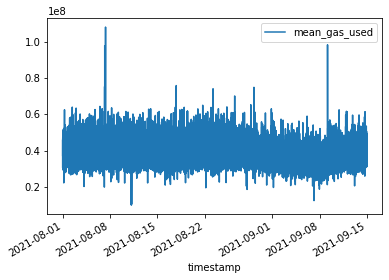

In [5]:
derived_gas_outputs_seconds.plot(x='timestamp',y='mean_gas_used')

<AxesSubplot:xlabel='timestamp'>

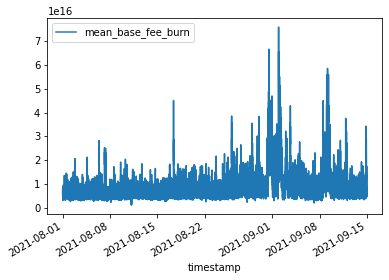

In [6]:
derived_gas_outputs_seconds.plot(x='timestamp',y='mean_base_fee_burn')

From the above plots of base fee burned, we can see a dramatic increase during the first couple days of September and then a trend towards the mean. Gas used has two spikes but maintains relatively consistent throughout the period. Of particular interest is *which* methods drove up the base fee. Specifically, the question has been asked if PublishStorageDeals or storagemarket/4 is responsible for much of the increase. We will uncover below. To do so we will look at the count of each actor/method during each day.

In [7]:
QUERY = """
SELECT 
date_trunc('day', 
to_timestamp(height_to_unix(d.height))) AS timestamp,
d.actor_name as Actor_name,
d.method as Method_number,
COUNT(CAST(d.gas_used AS FLOAT)) as method_count_per_day,
SUM(CAST(d.gas_used AS FLOAT)) as total_gas_used_per_day
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-08-01' AND '2021-09-15'
GROUP BY
Actor_name,
Method_number,
timestamp
ORDER BY 
timestamp ASC
"""
derived_gas_outputs_message_level_count = (pd.read_sql(QUERY, connection))




In [8]:
derived_gas_outputs_message_level_count

,timestamp,actor_name,method_number,method_count_per_day,total_gas_used_per_day
0,2021-08-01 00:00:00+00:00,fil/5/account,0,26492,1.586083e+10
1,2021-08-01 00:00:00+00:00,fil/5/init,2,3,3.438478e+07
2,2021-08-01 00:00:00+00:00,fil/5/multisig,0,80,3.913494e+07
3,2021-08-01 00:00:00+00:00,fil/5/multisig,2,1423,5.378701e+09
4,2021-08-01 00:00:00+00:00,fil/5/multisig,3,14,1.743370e+08
...,...,...,...,...,...
1234,2021-09-15 00:00:00+00:00,fil/5/storageminer,5,40,4.893179e+08
1235,2021-09-15 00:00:00+00:00,fil/5/storageminer,6,171,2.794827e+09
1236,2021-09-15 00:00:00+00:00,fil/5/storageminer,7,275,1.414712e+10
1237,2021-09-15 00:00:00+00:00,fil/5/storageminer,25,20,1.026099e+09


In [9]:
# unit_vector and angle_between from: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#Calculate cosine angle change between each day.
def day_subset_vector(df,date1,date2,vector):
    '''
    '''
    mask1 = df['timestamp'] == date1
    mask2 = df['timestamp'] == date2
    df1 = df.loc[mask1]
    df2 = df.loc[mask2]
    v1 = df1[vector].values
    v2 = df2[vector].values
    angle = angle_between(v1,v2)
    return angle


def daily_bar_chart(df,timestamp,y):
    '''
    '''
    mask = df['timestamp'] == timestamp
    df = df.loc[mask]
    df.plot.bar(x='actor+method', y=y)

We will iterate through the 'trouble period' and look at the daily bar charts of method counts

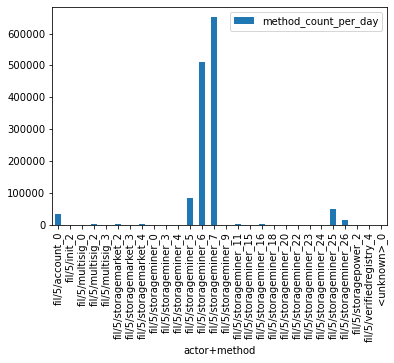

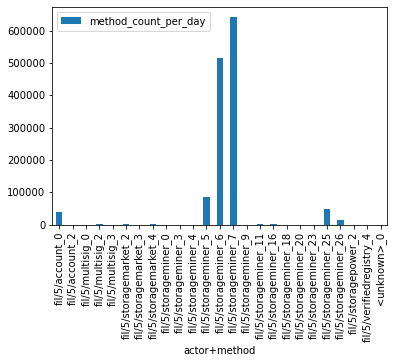

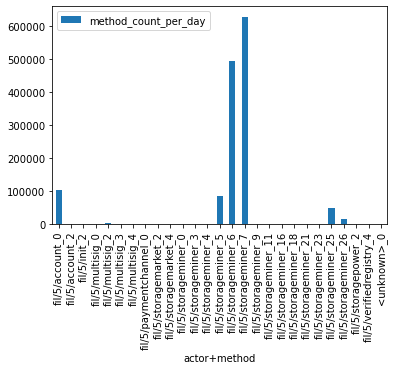

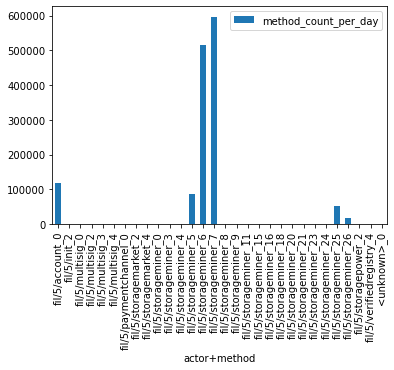

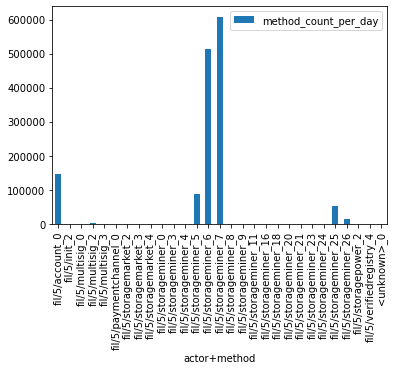

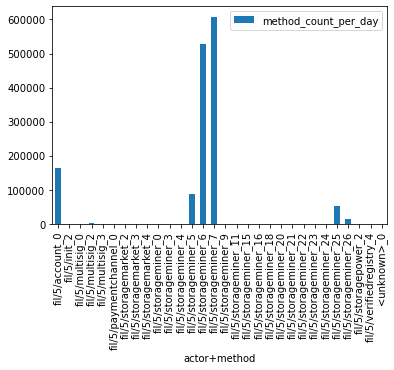

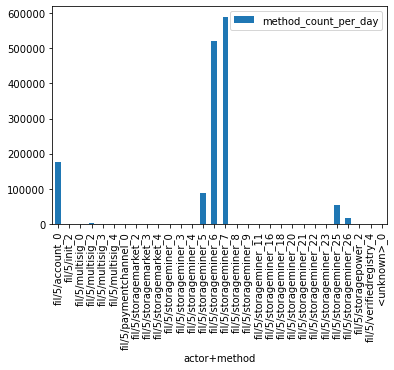

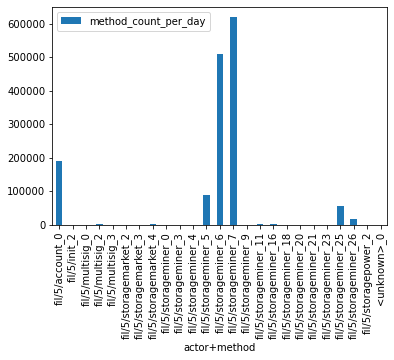

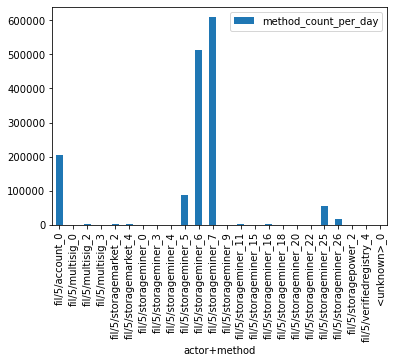

In [12]:
derived_gas_outputs_message_level_count['actor+method'] = derived_gas_outputs_message_level_count['actor_name'] + '_' + derived_gas_outputs_message_level_count['method_number'].astype(str) 

timestamps = ['2021-08-28 00:00:00+00:00','2021-08-29 00:00:00+00:00','2021-08-30 00:00:00+00:00',
             '2021-08-31 00:00:00+00:00','2021-09-01 00:00:00+00:00','2021-09-02 00:00:00+00:00',
             '2021-09-03 00:00:00+00:00','2021-09-04 00:00:00+00:00','2021-09-05 00:00:00+00:00']

for i in timestamps:
    daily_bar_chart(derived_gas_outputs_message_level_count,i,'method_count_per_day')

The results from the bar charts above are inconclusive, so we will move to some outlier detection to dig down into the driving factors.

In [13]:
derived_gas_outputs_message_level_count.describe()

,method_number,method_count_per_day,total_gas_used_per_day
count,1239.000000,1239.000000,1.239000e+03
mean,8.376917,48614.050040,1.800080e+12
std,8.521141,146894.477938,6.343208e+12
min,0.000000,1.000000,4.269360e+05
25%,2.000000,9.000000,1.905546e+07
50%,4.000000,37.000000,4.336963e+08
75%,16.000000,1382.500000,1.917210e+10
max,26.000000,683269.000000,3.612153e+13


In [14]:
# we will calculate the per day total counts which will provide us the ability to 'normalize' method counts
per_day_total_counts = derived_gas_outputs_message_level_count.groupby('timestamp').sum('method_count_per_day').reset_index()

In [15]:
per_day_total_counts['method_count_per_day_total'] = per_day_total_counts['method_count_per_day']
del per_day_total_counts['method_count_per_day']
del per_day_total_counts['method_number']
del per_day_total_counts['total_gas_used_per_day']

The counts per method/actor per day is a good first step in order to help us back into which methods increased the most. To narrow down the scope, we will look look at descriptive statistics for the number of method_count_per_day and subset method/actors over 75%.

We will now add percentage of daily totals as well as weekly percentage change, which is the method_count_per_day with a rolling percentage change of 7 periods, which in this case, is days.

In [16]:
derived_gas_outputs_message_level_count = pd.merge(derived_gas_outputs_message_level_count,per_day_total_counts, on='timestamp')
derived_gas_outputs_message_level_count['percentage_of_daily_total'] = derived_gas_outputs_message_level_count['method_count_per_day'] / derived_gas_outputs_message_level_count['method_count_per_day_total']
derived_gas_outputs_message_level_count['Week_percentage_change'] = derived_gas_outputs_message_level_count['method_count_per_day'].pct_change(periods=7)
derived_gas_outputs_message_level_count['mean_gas_used_per_method'] = derived_gas_outputs_message_level_count['method_count_per_day']/derived_gas_outputs_message_level_count['total_gas_used_per_day']

From the descriptive statistics, we can see that the 75% is 1382.5 We will subset the counts to only methods/actors with greater than 1,382 per day.

In [17]:
seventy_five_derived_gas_outputs_message_level_count = derived_gas_outputs_message_level_count.query('method_count_per_day >1382.5')

In [18]:
# now we will subset to August 2 and September 2nd
seventy_five_derived_gas_outputs_message_level_count_august = seventy_five_derived_gas_outputs_message_level_count.query('timestamp =="2021-08-02 00:00:00+00:00"')
seventy_five_derived_gas_outputs_message_level_count_september = seventy_five_derived_gas_outputs_message_level_count.query('timestamp =="2021-09-02 00:00:00+00:00"')

In [19]:
# now we will look at the counts
seventy_five_derived_gas_outputs_message_level_count_august


,timestamp,actor_name,method_number,method_count_per_day,total_gas_used_per_day,actor+method,method_count_per_day_total,percentage_of_daily_total,Week_percentage_change,mean_gas_used_per_method
26,2021-08-02 00:00:00+00:00,fil/5/account,0,29807,1.824074e+10,fil/5/account_0,1270042,0.023469,2291.846154,1.634090e-06
29,2021-08-02 00:00:00+00:00,fil/5/multisig,2,1410,5.311229e+09,fil/5/multisig_2,1270042,0.001110,-0.872329,2.654753e-07
37,2021-08-02 00:00:00+00:00,fil/5/storageminer,5,73912,1.170225e+12,fil/5/storageminer_5,1270042,0.058197,1393.566038,6.316048e-08
38,2021-08-02 00:00:00+00:00,fil/5/storageminer,6,445160,7.053312e+12,fil/5/storageminer_6,1270042,0.350508,34242.076923,6.311362e-08
39,2021-08-02 00:00:00+00:00,fil/5/storageminer,7,664581,3.489646e+13,fil/5/storageminer_7,1270042,0.523275,522.292126,1.904437e-08
48,2021-08-02 00:00:00+00:00,fil/5/storageminer,25,42064,2.230881e+12,fil/5/storageminer_25,1270042,0.033120,46.209877,1.885533e-08
49,2021-08-02 00:00:00+00:00,fil/5/storageminer,26,9320,3.428189e+12,fil/5/storageminer_26,1270042,0.007338,11.611637,2.718637e-09


In [20]:
seventy_five_derived_gas_outputs_message_level_count_september

,timestamp,actor_name,method_number,method_count_per_day,total_gas_used_per_day,actor+method,method_count_per_day_total,percentage_of_daily_total,Week_percentage_change,mean_gas_used_per_method
875,2021-09-02 00:00:00+00:00,fil/5/account,0,165247,8.568571e+10,fil/5/account_0,1462199,0.113013,3371.387755,1.928525e-06
878,2021-09-02 00:00:00+00:00,fil/5/multisig,2,1519,5.703267e+09,fil/5/multisig_2,1462199,0.001039,-0.895652,2.663386e-07
887,2021-09-02 00:00:00+00:00,fil/5/storageminer,5,86807,1.303169e+12,fil/5/storageminer_5,1462199,0.059367,6676.461538,6.661222e-08
888,2021-09-02 00:00:00+00:00,fil/5/storageminer,6,527397,9.448254e+12,fil/5/storageminer_6,1462199,0.360688,531.724242,5.581952e-08
889,2021-09-02 00:00:00+00:00,fil/5/storageminer,7,607656,3.063702e+13,fil/5/storageminer_7,1462199,0.415577,607655.000000,1.983404e-08
900,2021-09-02 00:00:00+00:00,fil/5/storageminer,25,53840,2.601624e+12,fil/5/storageminer_25,1462199,0.036821,80.948250,2.069477e-08
901,2021-09-02 00:00:00+00:00,fil/5/storageminer,26,15793,5.140966e+12,fil/5/storageminer_26,1462199,0.010801,508.451613,3.071991e-09


Below we are plotting the weekly percentage change of the actors and methods for both August 2nd and September 2nd. 

<AxesSubplot:title={'center':'Week of August 2nd'}, xlabel='actor+method'>

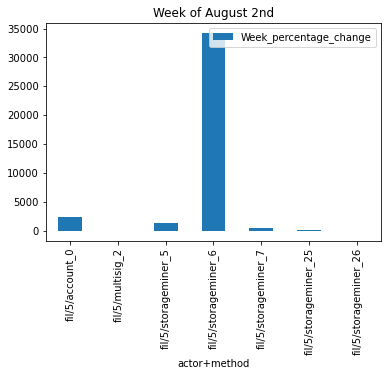

In [21]:
seventy_five_derived_gas_outputs_message_level_count_august.plot.bar(x='actor+method', y='Week_percentage_change', title='Week of August 2nd')

<AxesSubplot:title={'center':'Week of September 2nd'}, xlabel='actor+method'>

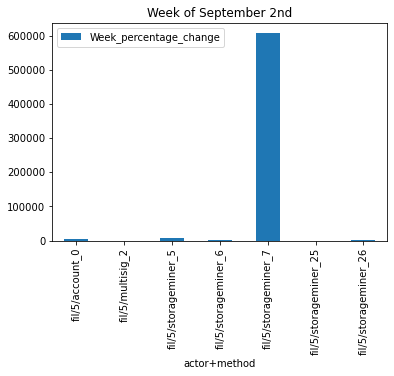

In [22]:
# now we will look at the counts
seventy_five_derived_gas_outputs_message_level_count_september.plot.bar(x='actor+method', y='Week_percentage_change', title='Week of September 2nd')

From the above graphic, we can see that StorageMiner 7, which corresponds to ProveCommitSector [per](https://github.com/filecoin-project/specs-actors/blob/master/actors/builtin/miner/miner_actor.go) had a massive, massive weekly percentage change from August 26th to September 2nd.

To try and find any outlier methods across the whole time period, we will filter again based of Week_percentage_change outliers to see which methods changed the most.

In [23]:
derived_gas_outputs_message_level_count.describe()

,method_number,method_count_per_day,total_gas_used_per_day,method_count_per_day_total,percentage_of_daily_total,Week_percentage_change,mean_gas_used_per_method
count,1239.000000,1239.000000,1.239000e+03,1.239000e+03,1.239000e+03,1232.000000,1.239000e+03
mean,8.376917,48614.050040,1.800080e+12,1.333032e+06,3.712672e-02,16466.428924,4.740031e-07
std,8.521141,146894.477938,6.343208e+12,1.240604e+05,1.113732e-01,87171.725741,6.729240e-07
min,0.000000,1.000000,4.269360e+05,5.180000e+02,6.246603e-07,-0.999999,1.633977e-10
25%,2.000000,9.000000,1.905546e+07,1.280471e+06,6.961128e-06,-0.973952,5.421456e-08
50%,4.000000,37.000000,4.336963e+08,1.302755e+06,2.901142e-05,0.637218,1.180922e-07
75%,16.000000,1382.500000,1.917210e+10,1.376948e+06,1.069415e-03,45.927469,5.851432e-07
max,26.000000,683269.000000,3.612153e+13,1.600870e+06,5.334176e-01,683268.000000,2.342271e-06


We will now look at the weekly percentage change for the time period of interest, August 28th through September 4th.

In [33]:
seventy_five_change_derived_gas_outputs_message_level_count = derived_gas_outputs_message_level_count.query('Week_percentage_change >45.92747')
mask = (seventy_five_change_derived_gas_outputs_message_level_count['timestamp'] >= '2021-08-28 00:00:00+00:00') & (seventy_five_change_derived_gas_outputs_message_level_count['timestamp'] <= '2021-09-04 00:00:00+00:00')
seventy_five_change_derived_gas_outputs_message_level_count = seventy_five_change_derived_gas_outputs_message_level_count.loc[mask]

In [34]:
seventy_five_change_derived_gas_outputs_message_level_count.sort_values(by='Week_percentage_change',ascending=False)

,timestamp,actor_name,method_number,method_count_per_day,total_gas_used_per_day,actor+method,method_count_per_day_total,percentage_of_daily_total,Week_percentage_change,mean_gas_used_per_method
777,2021-08-29 00:00:00+00:00,fil/5/storageminer,7,640947,3.244040e+13,fil/5/storageminer_7,1350181,0.474712,640946.000000,1.975768e-08
948,2021-09-04 00:00:00+00:00,fil/5/storageminer,7,618500,3.168025e+13,fil/5/storageminer_7,1479891,0.417936,618499.000000,1.952321e-08
889,2021-09-02 00:00:00+00:00,fil/5/storageminer,7,607656,3.063702e+13,fil/5/storageminer_7,1462199,0.415577,607655.000000,1.983404e-08
749,2021-08-28 00:00:00+00:00,fil/5/storageminer,7,650536,3.324986e+13,fil/5/storageminer_7,1347562,0.482750,325267.000000,1.956507e-08
860,2021-09-01 00:00:00+00:00,fil/5/storageminer,7,608166,3.075375e+13,fil/5/storageminer_7,1429864,0.425331,202721.000000,1.977534e-08
920,2021-09-03 00:00:00+00:00,fil/5/storageminer,7,589753,2.977116e+13,fil/5/storageminer_7,1451540,0.406295,196583.333333,1.980954e-08
935,2021-09-04 00:00:00+00:00,fil/5/account,0,189283,9.703242e+10,fil/5/account_0,1479891,0.127903,189282.000000,1.950719e-06
829,2021-08-31 00:00:00+00:00,fil/5/storageminer,6,515559,9.406809e+12,fil/5/storageminer_6,1389073,0.371153,171852.000000,5.480700e-08
789,2021-08-30 00:00:00+00:00,fil/5/account,0,101976,5.368732e+10,fil/5/account_0,1376948,0.074059,101975.000000,1.899443e-06
828,2021-08-31 00:00:00+00:00,fil/5/storageminer,5,85910,1.282367e+12,fil/5/storageminer_5,1389073,0.061847,85909.000000,6.699330e-08


The analysis shows that the majority of the increase is from storage miner, specifically methods 7 (ProveCommitSector),6(PreCommitSector),5(SubmitWindowedPoSt), and 25(PreCommitSectorBatch), although other actors and methods increased as well.

Additionally, we are working on a vector angle calculation that will give us an additional tool for determining method changes.

In [26]:
first = ['2021-08-29','2021-09-01','2021-09-02',
        '2021-09-03','2021-09-04']
angle = []
angle.append(day_subset_vector(seventy_five_derived_gas_outputs_message_level_count,'2021-08-29 00:00:00+00:00',
                 '2021-08-30 00:00:00+00:00','method_count_per_day'))

angle.append(day_subset_vector(seventy_five_derived_gas_outputs_message_level_count,'2021-09-01 00:00:00+00:00',
                 '2021-09-02 00:00:00+00:00','method_count_per_day'))

angle.append(day_subset_vector(seventy_five_derived_gas_outputs_message_level_count,'2021-09-02 00:00:00+00:00',
                 '2021-09-03 00:00:00+00:00','method_count_per_day'))

angle.append(day_subset_vector(seventy_five_derived_gas_outputs_message_level_count,'2021-09-03 00:00:00+00:00',
                 '2021-09-04 00:00:00+00:00','method_count_per_day'))

angle.append(day_subset_vector(seventy_five_derived_gas_outputs_message_level_count,'2021-09-04 00:00:00+00:00',
                 '2021-09-05 00:00:00+00:00','method_count_per_day'))

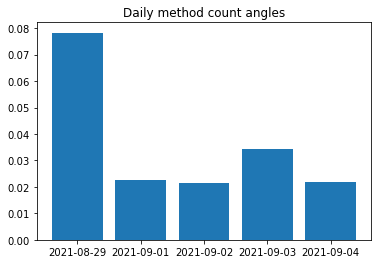

In [27]:
plt.bar(first, angle, width=0.8)
plt.title('Daily method count angles')
plt.show()

The angle change plot shows us that there was a change in the angle distributions on August 29th. We will examine total_gas_used_per_day, method_count_per_day, and mean_gas_used_per_method to look for any other observable changes.

<AxesSubplot:xlabel='timestamp'>

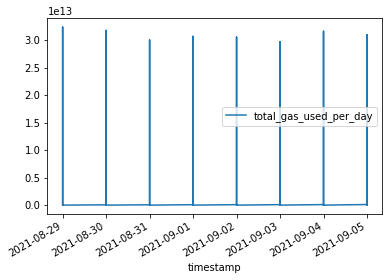

In [28]:
mask = (derived_gas_outputs_message_level_count['timestamp'] > '2021-08-28 00:00:00+00:00') & (derived_gas_outputs_message_level_count['timestamp'] <= '2021-09-05 00:00:00+00:00')
plot = derived_gas_outputs_message_level_count.loc[mask]

plot.plot(x='timestamp',y='total_gas_used_per_day')

<AxesSubplot:xlabel='timestamp'>

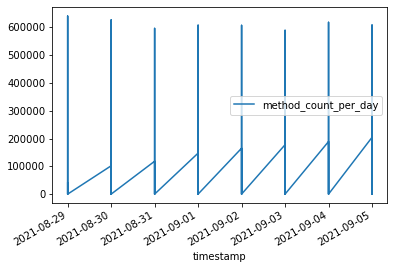

In [29]:
plot.plot(x='timestamp',y='method_count_per_day')

<AxesSubplot:xlabel='timestamp'>

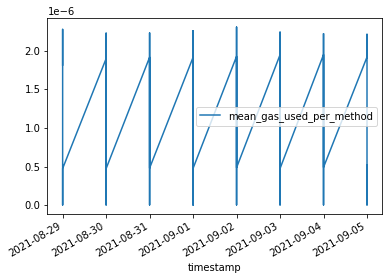

In [30]:
plot.plot(x='timestamp',y='mean_gas_used_per_method')

The three proceeding plots do not show any meaningful patterns.

## Conclusion

Based on our analysis, it appears that the increase in basefee is not isolated to the storagemarket PublishStorageDeals method, but in fact appears to be more from the ProveCommitSector, amongst other methods.